# 1. Preprocessing

In [51]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

## 1.1 Converting File Format


In [ ]:
pip install pdfplumber

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pdfplumber
import warnings
import logging

# To ignore the warnings
warnings.filterwarnings("ignore")
logging.getLogger("pdfminer").setLevel(logging.ERROR)

with pdfplumber.open('killed-in-gaza_moh_2025-03-23.pdf') as pdf:
    total_pages = len(pdf.pages)
    batch_size = 50  # process 50 pages at a time
    batch_number = 1

    for start_page in range(0, total_pages, batch_size):
        end_page = min(start_page + batch_size, total_pages)
        print(f"Processing pages {start_page+1} to {end_page}...")

        batch_rows = []
        columns = None

        for page_num in range(start_page, end_page):
            page = pdf.pages[page_num]
            table = page.extract_table()
            if table:
                if columns is None:
                    columns = table[0]  # first page -> header
                    batch_rows.extend(table[1:])  # first page -> skip header
                else:
                    batch_rows.extend(table)  # other pages -> take all rows

        if batch_rows:
            # Building a small Table for this batch
            batch_table = Table().with_columns(*[(col, []) for col in columns])

            for row in batch_rows:
                batch_table = batch_table.with_row(row)

            # Saving this batch separately
            filename = f'killed_in_gaza_batch_{batch_number}.csv'
            batch_table.to_csv(filename)

        batch_number += 1

Processing pages 1 to 50...
Processing pages 51 to 100...
Processing pages 101 to 150...
Processing pages 151 to 200...
Processing pages 201 to 250...
Processing pages 251 to 300...
Processing pages 301 to 350...
Processing pages 351 to 400...
Processing pages 401 to 450...
Processing pages 451 to 500...
Processing pages 501 to 550...
Processing pages 551 to 600...
Processing pages 601 to 650...
Processing pages 651 to 700...
Processing pages 701 to 750...
Processing pages 751 to 800...
Processing pages 801 to 850...
Processing pages 851 to 900...
Processing pages 901 to 950...
Processing pages 951 to 981...


In [ ]:
import csv
import glob
import os

# Finding all CSV files
csv_files = sorted(glob.glob('killed_in_gaza_batch_*.csv'))

# Creating a file to store the combined output
with open('killed_in_gaza.csv', 'w', encoding='utf-8-sig', newline='') as output_file:
    writer = None

    for filename in csv_files:
        with open(filename, 'r', encoding='utf-8-sig') as f:
            reader = csv.reader(f)

            if writer is None:
                headers = next(reader)  # read header
                writer = csv.writer(output_file)
                writer.writerow(headers)

            for row in reader:
                writer.writerow(row)
        os.remove(filename)


In [ ]:
import json

# Loading JSON
with open('infrastructure-damaged_2025-04-12.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Flattening records
flattened_data = []

for record in data:
    flat_record = {}
    for key, value in record.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                flat_record[f"{key}_{sub_key}"] = sub_value
        else:
            flat_record[key] = value
    flattened_data.append(flat_record)

# Finding all possible headers from all records
all_keys = set()
for row in flattened_data:
    all_keys.update(row.keys())

# headers = sorted(all_keys)

# Saving to CSV
with open('infrastructure_damaged.csv', 'w', newline='', encoding='utf-8-sig') as f:
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()

    for row in flattened_data:
        # filling missing keys with 0
        complete_row = {key: row.get(key, 0) for key in headers}
        writer.writerow(complete_row)


## 1.2 Datasets

In [3]:
daily_casualties_gaza = Table.read_table('casualties_daily_gaza_2025-04-12.csv')
daily_casualties_gaza.show(10)

report_date,report_source,report_period,ext_massacres_cum,killed,killed_cum,ext_killed,ext_killed_cum,ext_killed_children_cum,ext_killed_women_cum,injured_cum,ext_injured,ext_injured_cum,ext_civdef_killed_cum,med_killed_cum,ext_med_killed_cum,press_killed_cum,ext_press_killed_cum
2023-10-07,mohtel,24,0,232,232,232,232,0,0,1610,1610,1610,0,6,6,1,1
2023-10-08,mohtel,24,0,138,370,138,370,78,41,1788,178,1788,0,nan,6,1,1
2023-10-09,mohtel,24,8,190,560,190,560,91,61,2271,483,2271,0,6,6,3,3
2023-10-10,mohtel,24,8,340,900,340,900,260,230,4000,1729,4000,0,nan,6,7,7
2023-10-11,gmotel,24,23,200,1100,200,1100,398,230,5184,1184,5184,0,10,10,nan,7
2023-10-12,mohtel,24,23,317,1417,317,1417,500,276,5763,579,5763,0,11,11,nan,7
2023-10-13,missing,24,23,483,1900,483,1900,500,392,nan,1475,7238,0,11,11,nan,7
2023-10-14,gmotel,24,23,328,2228,328,2228,600,600,8714,1476,8714,0,11,11,nan,7
2023-10-15,gmotel,24,23,442,2670,442,2670,700,735,9200,486,9200,0,nan,11,nan,7
2023-10-16,gmotel,24,371,138,2808,138,2808,853,936,10850,1650,10850,7,37,37,nan,7


In [5]:
daily_casualties_westbank = Table.read_table('casualties_daily_west_bank_2025-04-12.csv')
daily_casualties_westbank.show(5)

report_date,verified.killed,verified.killed_cum,verified.injured,verified.injured_cum,verified.killed_children,verified.killed_children_cum,verified.injured_children,verified.injured_children_cum,killed_cum,killed_children_cum,injured_cum,injured_children_cum,settler_attacks_cum,flash_source
2023-10-07,6,6,197,197,2,2,31,31,3,0,23,1,3,un
2023-10-08,8,14,127,324,3,5,7,38,13,1,194,1,9,un
2023-10-09,4,18,88,412,0,5,19,57,15,3,295,34,19,un
2023-10-10,5,23,72,484,0,5,7,64,19,3,332,39,29,un
2023-10-11,6,29,85,569,2,7,17,81,26,3,427,62,39,un


In [65]:
killed_in_gaza = Table.read_table('killed_in_gaza.csv')
# killed_in_gaza.sort("Index", descending=True).show(5)
killed_in_gaza.show(5)

Index,Name,مس#ا,Born,Age,Sex,ID number
1,Mohammed Hani Mohammed Al-Zahhar,راهزلا دمحم يناه دمحم,2023-08-09,0,m,444196471
2,Nour Mohammed Aed Udwan,ناودع دئاع دمحم رون,2023-02-27,0,f,444484729
3,Khaled Mumin Amin Shabir,ريبش 6ما نمؤم دلاخ,2023-04-16,0,m,444799647
4,Yamen Ibrahim Farid Qaddoura,هرودق ديرف ميهاربا نماي,2023-06-10,0,m,445958408
5,Ahmed Rami Ahmed Abdel Qadir,رداقلا دبع دمحأ يمار دمحأ,2022-12-22,0,m,445808546


In [9]:
infrastructure_damaged = Table.read_table('infrastructure_damaged.csv')

# Making report_date the first column
labels = list(infrastructure_damaged.labels)
labels.remove('report_date')
new_order = ['report_date'] + labels  # Put it first

# Rearrange the Table
infrastructure_damaged = infrastructure_damaged.select(new_order)

infrastructure_damaged.show(5)

report_date,civic_buildings_destroyed,civic_buildings_ext_destroyed,educational_buildings_damaged,educational_buildings_destroyed,educational_buildings_ext_damaged,educational_buildings_ext_destroyed,places_of_worship_churches_destroyed,places_of_worship_ext_churches_destroyed,places_of_worship_ext_mosques_damaged,places_of_worship_ext_mosques_destroyed,places_of_worship_mosques_damaged,places_of_worship_mosques_destroyed,residential_destroyed,residential_ext_destroyed
2023-10-07,0,5,0,0,15,1,0,0,4,2,0,0,0,80
2023-10-08,0,11,0,0,30,1,0,0,8,4,0,0,159,159
2023-10-09,0,16,0,0,45,2,0,0,12,6,0,0,790,790
2023-10-10,0,22,0,0,60,2,0,0,17,8,0,0,1009,1009
2023-10-11,27,27,75,3,75,3,0,0,21,10,0,10,2835,2835


## 1.3 Data Quality Assessment

Before analyzing our datasets, we need to understand their quality and identify any issues that might affect our analysis.
We'll examine all columns in each dataset to identify missing values and understand patterns in the data.

Because of the challenging conditions under which this data is collected, we expect to see some gaps. By understanding these gaps, we can make appropriate cleaning decisions that preserve the integrity of the data.

In [12]:
def check_dataset_quality(table, dataset_name):
    """
    Checks the quality of an entire datascience.Table dataset.
    table: A datascience.Table object
    dataset_name: String with the name of the dataset for reporting
    """
    print(f"\n---------- CHECKING QUALITY OF {dataset_name} ----------")

    #create a results table
    results = Table().with_columns(
        'Column Name', [],
        'Data Type', [],
        'Count', [],
        'Num Missing', [],
        'Percent Missing', [],
        'Num Unique Values', [],
        'Min Value', [],
        'Max Value', []
    )

    num_rows = table.num_rows
    print(f"Total rows: {num_rows}")

    for col_name in table.labels:
        print(f"\nChecking column: {col_name}")

        #extract column as an array
        col_values = table.column(col_name)

        try:
            example_value = col_values.item(0) if num_rows > 0 else None
            data_type = type(example_value).__name__
        except:
            data_type = "unknown"

        #count missing/none values
        none_count = 0
        try:
            none_count = table.where(col_name, are.equal_to(None)).num_rows
        except:
            pass

        #np.nan
        nan_count = 0
        try:
            #for the numeric columns, check if values are NaN
            if data_type in ('int', 'float'):
                def is_nan(x):
                    try:
                        return np.isnan(x)
                    except:
                        return False

                # Apply the function to count NaNs
                nan_array = table.apply(is_nan, col_name)
                nan_count = sum(nan_array)
        except:
            pass

        #count empty strings for text columns
        empty_count = 0
        try:
            if data_type == 'str':
                empty_count = table.where(col_name, are.equal_to('')).num_rows
        except:
            pass

        #total missing
        total_missing = none_count + nan_count + empty_count
        percent_missing = (total_missing / num_rows * 100) if num_rows > 0 else 0

        #unique values
        unique_count = 0
        try:
            #group by the column and count unique values
            unique_count = table.group(col_name).num_rows
        except:
            pass

        #get min and max just to see if any unuslally small or large vals
        min_value = "N/A"
        max_value = "N/A"
        try:
            if data_type in ('int', 'float'):
                valid_values = table.where(col_name, are.not_equal_to(None)).column(col_name)
                if len(valid_values) > 0:
                    min_value = min(valid_values)
                    max_value = max(valid_values)
        except:
            pass

        results = results.with_row([
            col_name,
            data_type,
            num_rows,
            total_missing,
            round(percent_missing, 2),
            unique_count,
            min_value,
            max_value
        ])

    #print a summary
    problem_cols = results.where('Percent Missing', are.above(0))

    if problem_cols.num_rows > 0:
        print("\n----- SUMMARY OF DATA QUALITY ISSUES -----")
        print(f"Found {problem_cols.num_rows} columns with missing values:")
        problem_cols.select('Column Name', 'Percent Missing').show()
    else:
        print("\nNo missing values found in any columns!")

    return results



In [14]:
def check_all_datasets_quality():

    gaza_results = check_dataset_quality(daily_casualties_gaza, "GAZA CASUALTIES")
    westbank_results = check_dataset_quality(daily_casualties_westbank, "WEST BANK CASUALTIES")
    infra_results = check_dataset_quality(infrastructure_damaged, "INFRASTRUCTURE DAMAGE")
    killed_results = check_dataset_quality(killed_in_gaza, "KILLED IN GAZA")

    all_datasets = Table().with_columns(
        'Dataset', ['Gaza Casualties', 'West Bank Casualties', 'Infrastructure Damage', 'Killed in Gaza'],
        'Rows', [
            daily_casualties_gaza.num_rows,
            daily_casualties_westbank.num_rows,
            infrastructure_damaged.num_rows,
            killed_in_gaza.num_rows
        ],
        'Columns', [
            len(daily_casualties_gaza.labels),
            len(daily_casualties_westbank.labels),
            len(infrastructure_damaged.labels),
            len(killed_in_gaza.labels)
        ]
    )

    print("\n---------- OVERALL DATASET SUMMARY ----------")
    all_datasets.show()

    return gaza_results, westbank_results, infra_results, killed_results

gaza_results, westbank_results, infra_results, killed_results = check_all_datasets_quality()


---------- CHECKING QUALITY OF GAZA CASUALTIES ----------
Total rows: 551

Checking column: report_date

Checking column: report_source

Checking column: report_period

Checking column: ext_massacres_cum

Checking column: killed

Checking column: killed_cum

Checking column: ext_killed

Checking column: ext_killed_cum

Checking column: ext_killed_children_cum

Checking column: ext_killed_women_cum

Checking column: injured_cum

Checking column: ext_injured

Checking column: ext_injured_cum

Checking column: ext_civdef_killed_cum

Checking column: med_killed_cum

Checking column: ext_med_killed_cum

Checking column: press_killed_cum

Checking column: ext_press_killed_cum

----- SUMMARY OF DATA QUALITY ISSUES -----
Found 5 columns with missing values:


Column Name,Percent Missing
killed,4.9
killed_cum,1.27
injured_cum,2.72
med_killed_cum,75.68
press_killed_cum,74.23



---------- CHECKING QUALITY OF WEST BANK CASUALTIES ----------
Total rows: 551

Checking column: report_date

Checking column: verified.killed

Checking column: verified.killed_cum

Checking column: verified.injured

Checking column: verified.injured_cum

Checking column: verified.killed_children

Checking column: verified.killed_children_cum

Checking column: verified.injured_children

Checking column: verified.injured_children_cum

Checking column: killed_cum

Checking column: killed_children_cum

Checking column: injured_cum

Checking column: injured_children_cum

Checking column: settler_attacks_cum

Checking column: flash_source

----- SUMMARY OF DATA QUALITY ISSUES -----
Found 8 columns with missing values:


Column Name,Percent Missing
verified.killed,26.86
verified.killed_cum,26.68
verified.injured,29.4
verified.injured_cum,29.04
verified.killed_children,26.86
verified.killed_children_cum,26.68
verified.injured_children,29.4
verified.injured_children_cum,29.04



---------- CHECKING QUALITY OF INFRASTRUCTURE DAMAGE ----------
Total rows: 534

Checking column: report_date

Checking column: civic_buildings_destroyed

Checking column: civic_buildings_ext_destroyed

Checking column: educational_buildings_damaged

Checking column: educational_buildings_destroyed

Checking column: educational_buildings_ext_damaged

Checking column: educational_buildings_ext_destroyed

Checking column: places_of_worship_churches_destroyed

Checking column: places_of_worship_ext_churches_destroyed

Checking column: places_of_worship_ext_mosques_damaged

Checking column: places_of_worship_ext_mosques_destroyed

Checking column: places_of_worship_mosques_damaged

Checking column: places_of_worship_mosques_destroyed

Checking column: residential_destroyed

Checking column: residential_ext_destroyed

No missing values found in any columns!

---------- CHECKING QUALITY OF KILLED IN GAZA ----------
Total rows: 50020

Checking column: Index

Checking column: Name

Checking c

Dataset,Rows,Columns
Gaza Casualties,551,18
West Bank Casualties,551,15
Infrastructure Damage,534,15
Killed in Gaza,50020,7


**Gaza Casualties Dataset:**

Columns with low missing rates (1-5%): killed, killed_cum, injured_cum
Columns with high missing rates (~75%): med_killed_cum, press_killed_cum

**West Bank Casualties Dataset:**

Verified data columns missing ~27-29% of values
Non-verified columns have complete data

**Infrastructure Damage and Killed in Gaza datasets:**

No missing values detected - these datasets are complete

**-----------------------------------------------------**

These patterns make sense when we understand how the data is collected. According to the dataset documentation:

Medical personnel and journalist casualties in Gaza are updated less frequently (weekly) than other casualty numbers
West Bank casualties go through a verification process by UN personnel, which creates delays in reporting verified data
The "verified" columns in the West Bank dataset represent casualties independently confirmed by UN OCHA personnel


## 1.4 Data Cleaning Process

Based on our quality assessment and the dataset documentation, we'll implement cleaning strategies for each dataset with missing values while maintaining their integrity.


### 1.4.1 Cleaning Approach for Gaza Casualties Dataset

**Approach 1: Columns Updated Weekly**

For columns updated weekly (`med_killed_cum`, `press_killed_cum`):
* Use the corresponding `ext_med_killed_cum` and `ext_press_killed_cum` columns directly, as they mirror the manual forward-filling process based on the documentation.

**Approach 2: Columns with Few Missing Values**

For columns with few missing values (`killed`, `killed_cum`, `injured_cum`):
* Use the corresponding extrapolated (`ext_`) columns when original values are missing
* These `ext_` columns were created by the data providers specifically to fill gaps in the data


In [19]:
def clean_gaza_casualties(gaza_table):
    """
    Cleans the Gaza casualties dataset by:
    1. Filling missing values in killed, killed_cum, and injured_cum columns using corresponding ext_ columns.
    2. Replacing med_killed_cum and press_killed_cum entirely with ext_med_killed_cum and ext_press_killed_cum.
    """
    #a copy of the original table
    cleaned = gaza_table.copy()

    # Helper function to fill using ext_ column when available
    def fill_from_ext_column(table, column_name):
        values = table.column(column_name)
        ext_column = f'ext_{column_name}'
        ext_values = table.column(ext_column)
        filled_values = make_array()

        for i in range(len(values)):
            #check value is missing
            is_missing = False
            try:
                if values.item(i) is None or (isinstance(values.item(i), float) and np.isnan(values.item(i))):
                    is_missing = True
            except:
                pass

            #if missing, use expt value
            if is_missing:
                filled_values = np.append(filled_values, ext_values.item(i))
            else:
                filled_values = np.append(filled_values, values.item(i))

        return filled_values
    
    if 'med_killed_cum' in cleaned.labels and 'ext_med_killed_cum' in cleaned.labels:
        cleaned = cleaned.with_column('med_killed_cum', cleaned.column('ext_med_killed_cum'))

    # overwrite press_killed_cum using ext
    if 'press_killed_cum' in cleaned.labels and 'ext_press_killed_cum' in cleaned.labels:
        cleaned = cleaned.with_column('press_killed_cum', cleaned.column('ext_press_killed_cum'))

    #fill killed using ext
    if 'killed' in cleaned.labels and 'ext_killed' in cleaned.labels:
        filled_killed = fill_from_ext_column(cleaned, 'killed')
        cleaned = cleaned.with_column('killed', filled_killed)

    #fill cumulative killed count using ext
    if 'killed_cum' in cleaned.labels and 'ext_killed_cum' in cleaned.labels:
        filled_killed_cum = fill_from_ext_column(cleaned, 'killed_cum')
        cleaned = cleaned.with_column('killed_cum', filled_killed_cum)

    #fill cumulative injured count using ext
    if 'injured_cum' in cleaned.labels and 'ext_injured_cum' in cleaned.labels:
        filled_injured_cum = fill_from_ext_column(cleaned, 'injured_cum')
        cleaned = cleaned.with_column('injured_cum', filled_injured_cum)

    return cleaned

### 1.4.2 Cleaning Approach for West Bank Dataset

For the West Bank dataset, we'll create two  datasets:

**Dataset 1: Verified-Only Table**

* Preserves only UN-verified data with its gaps
* This dataset has the high reliability but contains gaps in the data

**Dataset 2: Complete Table**

* Uses non-verified data to fill gaps when verified data is missing
* This dataset provides a complete timeline but with less verification

**This approach gives us flexibility:**
* When accuracy is needed, we can use the verified-only dataset
* When analyzing trends over time, we can use the complete dataset

In [22]:
def prepare_west_bank_data(wb_table):
    """
    Creates two tables from West Bank data:
    1. verified_only: contains only verified casualty data (for trustworthy analysis)
    2. complete: uses non-verified data to fill gaps (for timeline analysis)
    """
    #create a table with only verified data (has gaps but is confirmed)
    verified_only = wb_table.select(
        'report_date',
        'verified.killed_cum',
        'verified.injured_cum',
        'verified.killed_children_cum',
        'verified.injured_children_cum'
    )

    #create a complete table using non-verified data (fewer gaps) to replaces missing verified data with corresponding non-verified column
    #helper function to combine verified and non-verified columns
    def combine_verified_with_fallback(verified_col, fallback_col):
        combined = make_array()

        for i in range(len(verified_col)):
            is_missing = False
            try:
                if verified_col.item(i) is None or (isinstance(verified_col.item(i), float) and np.isnan(verified_col.item(i))):
                    is_missing = True
            except:
                pass

            #if missing use the non verified value as fallback
            if is_missing:
                combined = np.append(combined, fallback_col.item(i))
            else:
                combined = np.append(combined, verified_col.item(i))

        return combined

    #create complete table with combined data
    complete = Table().with_column('report_date', wb_table.column('report_date'))

    #add combined columns (verified when available, otherwise use non-verified)
    if 'verified.killed_cum' in wb_table.labels and 'killed_cum' in wb_table.labels:
        killed = combine_verified_with_fallback(
            wb_table.column('verified.killed_cum'),
            wb_table.column('killed_cum')
        )
        complete = complete.with_column('killed_cum', killed)

    if 'verified.injured_cum' in wb_table.labels and 'injured_cum' in wb_table.labels:
        injured = combine_verified_with_fallback(
            wb_table.column('verified.injured_cum'),
            wb_table.column('injured_cum')
        )
        complete = complete.with_column('injured_cum', injured)

    if 'verified.killed_children_cum' in wb_table.labels and 'killed_children_cum' in wb_table.labels:
        killed_children = combine_verified_with_fallback(
            wb_table.column('verified.killed_children_cum'),
            wb_table.column('killed_children_cum')
        )
        complete = complete.with_column('killed_children_cum', killed_children)

    if 'verified.injured_children_cum' in wb_table.labels and 'injured_children_cum' in wb_table.labels:
        injured_children = combine_verified_with_fallback(
            wb_table.column('verified.injured_children_cum'),
            wb_table.column('injured_children_cum')
        )
        complete = complete.with_column('injured_children_cum', injured_children)

    return verified_only, complete



### 1.4.3 Implementing the Data Cleaning
We apply our cleaning function them to our datasets and verify that they successfully address the missing values.

In [25]:
#clean the datasets
gaza_clean = clean_gaza_casualties(daily_casualties_gaza)
wb_verified, wb_complete = prepare_west_bank_data(daily_casualties_westbank)

#verification
def check_missing_values(table, name):
    """Check if any missing values remain in key columns"""
    print(f"\nChecking missing values in {name}:")

    for col in table.labels:
        #skip checking date columns and non numeric columns
        if 'date' in col or col == 'report_source' or col == 'flash_source':
            continue

        values = table.column(col)
        missing_count = 0

        for value in values:
            try:
                if value is None or (isinstance(value, float) and np.isnan(value)):
                    missing_count += 1
            except:
                pass

        if missing_count > 0:
            print(f"  {col}: {missing_count} missing values ({missing_count/table.num_rows*100:.2f}%)")

    print(f"check complete for {name}")

#verify
check_missing_values(gaza_clean, "Clean Gaza Casualties")
check_missing_values(wb_verified, "West Bank Verified Data")
check_missing_values(wb_complete, "West Bank Complete Data")


Checking missing values in Clean Gaza Casualties:
check complete for Clean Gaza Casualties

Checking missing values in West Bank Verified Data:
  verified.killed_cum: 147 missing values (26.68%)
  verified.injured_cum: 160 missing values (29.04%)
  verified.killed_children_cum: 147 missing values (26.68%)
  verified.injured_children_cum: 160 missing values (29.04%)
check complete for West Bank Verified Data

Checking missing values in West Bank Complete Data:
check complete for West Bank Complete Data


## 2. Exploratory Analysis & Visualization

<Figure size 640x480 with 0 Axes>

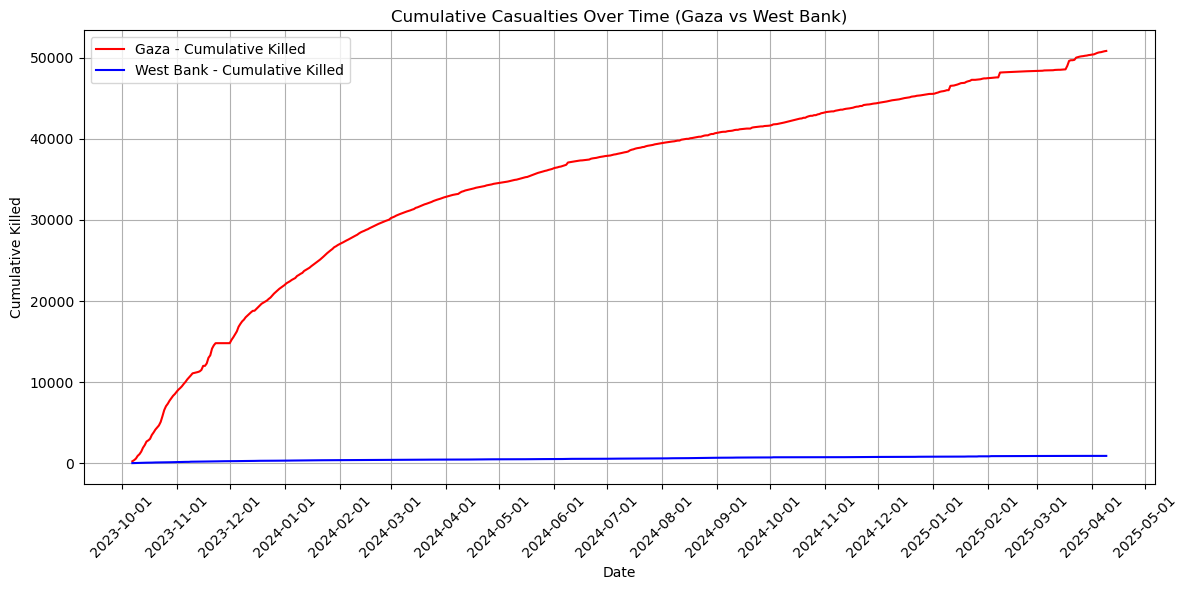

In [53]:
# casualities over time for gaza, westbank (overlaid line plot)

# Convert string dates to datetime objects
gaza_dates = [datetime.strptime(date, '%Y-%m-%d') for date in gaza_clean.column('report_date')]
wb_dates = [datetime.strptime(date, '%Y-%m-%d') for date in wb_complete.column('report_date')]

# Get the cumulative killed data
gaza_killed = gaza_clean.column('killed_cum')
wb_killed = wb_complete.column('killed_cum')

# Plot
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(gaza_dates, gaza_killed, label='Gaza - Cumulative Killed', color='red')
plt.plot(wb_dates, wb_killed, label='West Bank - Cumulative Killed', color='blue')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Killed')
plt.title('Cumulative Casualties Over Time (Gaza vs West Bank)')
plt.legend()
plt.grid(True)

# Adjust x-axis for date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Adjust the frequency of the ticks

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 600x400 with 0 Axes>

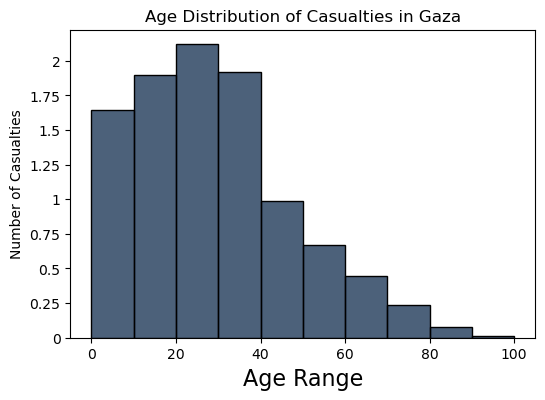

In [87]:
# age groups (in ranges) histogram (killed in gaza)

# Define custom bins (ranges)
bins = list(range(0, 101, 10))  # This will create bins like 0-10, 10-20, ..., 90-100

# Plot the histogram of ages with custom bins
plt.clf()
killed_in_gaza.hist('Age', bins=bins)

# Add titles and axis labels
plt.xlabel('Age Range')
plt.ylabel('Number of Casualties')
plt.title('Age Distribution of Casualties in Gaza')

# Display the plot
plt.show()


In [57]:
# join by report_date, number of building vs num killed in gaza (scatter)

Sex,count
f,16504
m,33516


<Figure size 640x480 with 0 Axes>

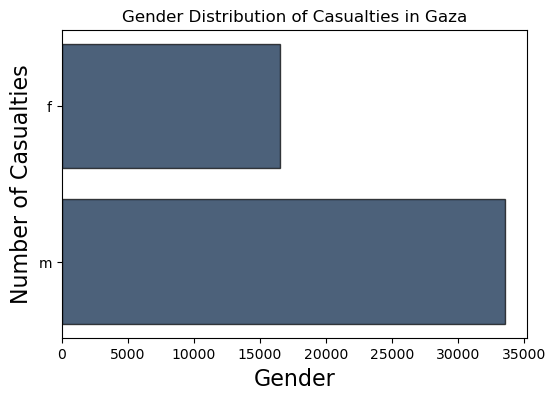

In [101]:
# group by gender (killed in gaza) bar chart

gender_counts = killed_in_gaza.group('Sex')
gender_counts.show()

plt.clf()

gender_counts.barh('Sex', 'count')

plt.xlabel('Number of Casualties')
plt.ylabel('Count')
plt.title('Gender Distribution of Casualties in Gaza')

plt.show()

In [ ]:
# something for period of ceasefire vs normal casualities

In [ ]:
# select just medical killed column vs time (and press)

In [ ]:
# settler attacks vs casualities over time in westband

## 3. Hypothesis Testing

In [ ]:
# null: woman and men are being targetted equally
# alternative: woman are being targetted more/ children
# statistic:

In [ ]:
# null: all ages are being targetted equally
# alternative: younger people (under a certain age)
# use td

In [ ]:
#
#
#